In [1]:
# Importación de Librerías Esenciales

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

<div class="alert alert-block alert-info">
    <h1>Taller Práctico: Regresión Lineal, Ridge y Lasso</h1>
    <p><strong>Objetivos de la sesión:</strong></p>
    <ul>
        <li>Aplicar los conceptos de regresión lineal en un problema práctico.</li>
        <li>Implementar y comparar modelos de Regresión Lineal, Ridge y Lasso.</li>
        <li>Utilizar la validación cruzada para encontrar el hiperparámetro de regularización óptimo.</li>
        <li>Evaluar el rendimiento de los modelos utilizando métricas como MSE, MAE y R².</li>
    </ul>
    <p><strong>Dataset:</strong> Utilizaremos el dataset "Ames Housing", que contiene información sobre la venta de casas en Ames, Iowa. Nuestro objetivo será predecir el precio de venta (<code>SalePrice</code>) de las casas.</p>
</div>

### 1. Carga y Exploración de Datos (EDA)

<p>El primer paso en cualquier proyecto de Machine Learning es entender nuestros datos. Cargaremos el dataset, veremos su estructura y realizaremos algunas visualizaciones iniciales.</p>

In [2]:
# Cargar el dataset Ames Housing desde OpenML
housing = fetch_openml(name="house_prices", as_frame=True)
df = housing.frame

df[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Cargar el dataset Ames Housing desde OpenML
housing = fetch_openml(name="house_prices", as_frame=True)
df = housing.frame

# Seleccionamos un subconjunto de características numéricas para simplificar el taller
# y la variable objetivo 'SalePrice'
numeric_features = ['GrLivArea', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'FullBath', 'GarageCars']
aditional_features=['LotFrontage','LotArea']
target_variable = 'SalePrice'

# Creamos un DataFrame más pequeño y manejamos valores faltantes de forma simple
df_subset = df[numeric_features + [target_variable]].dropna()

print(f"\nDimensiones del subconjunto de datos: {df_subset.shape}")
print("\nDescripción estadística del subconjunto:")
print(df_subset.describe())


Dimensiones del subconjunto de datos: (1460, 7)

Descripción estadística del subconjunto:
         GrLivArea  OverallQual    YearBuilt  TotalBsmtSF     FullBath  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1515.463699     6.099315  1971.267808  1057.429452     1.565068   
std     525.480383     1.382997    30.202904   438.705324     0.550916   
min     334.000000     1.000000  1872.000000     0.000000     0.000000   
25%    1129.500000     5.000000  1954.000000   795.750000     1.000000   
50%    1464.000000     6.000000  1973.000000   991.500000     2.000000   
75%    1776.750000     7.000000  2000.000000  1298.250000     2.000000   
max    5642.000000    10.000000  2010.000000  6110.000000     3.000000   

        GarageCars      SalePrice  
count  1460.000000    1460.000000  
mean      1.767123  180921.195890  
std       0.747315   79442.502883  
min       0.000000   34900.000000  
25%       1.000000  129975.000000  
50%       2.000000  163000

<p>Ahora, visualicemos la distribución de nuestra variable objetivo y la relación entre el área de la vivienda y su precio. La distribución de precios está sesgada, por lo que una transformación logarítmica será útil.</p>

In [4]:
# Histograma del Precio de Venta (SalePrice)
fig_hist = px.histogram(df_subset, x='SalePrice', nbins=50, title='Distribución del Precio de Venta de las Casas (Original)')
fig_hist.update_layout(xaxis_title='Precio de Venta (USD)', yaxis_title='Frecuencia')
fig_hist.show()

# Histograma del log(Precio de Venta)
fig_hist_log = px.histogram(x=np.log1p(df_subset['SalePrice']), nbins=50, title='Distribución del log(Precio de Venta)')
fig_hist_log.update_layout(xaxis_title='log(1 + Precio de Venta)', yaxis_title='Frecuencia')
fig_hist_log.show()



### 2. Preparación de Datos

<p>Ahora aplicaremos los cambios necesarios: división de datos, transformación logarítmica del objetivo y escalado de características.</p>

In [5]:
# 1. Definir características (X) y objetivo (y)
X = df_subset[numeric_features]
y_raw = df_subset[target_variable] # Guardamos el 'y' original para evaluación final

# !! CAMBIO CLAVE !!
# Aplicamos la transformación logarítmica a la variable objetivo 'y'
# Esto estabiliza la varianza y normaliza la escala del problema.
y = np.log1p(y_raw)

# 2. Dividir en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")

# 3. Escalar las características numéricas. (Normalizamos lo datos para que esten en el mismo rango)
scaler = StandardScaler()

# Ajustamos el escalador SOLO con los datos de entrenamiento para evitar fuga de datos (data leakage)
X_train_scaled = scaler.fit_transform(X_train)  # el fit hace el aprendizaje
# Aplicamos la misma transformación a los datos de prueba
X_test_scaled = scaler.transform(X_test)  # usa el mismo aprendizaje que antes. 

# Convertimos los arrays de numpy de vuelta a DataFrames de pandas para mejor legibilidad
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features)



Tamaño del set de entrenamiento: (1168, 6)
Tamaño del set de prueba: (292, 6)


# Transformación logarítmica de Y. (Pregunta)
Aplicar logaritmo a Y deja una relación log-lin donde puede interprestarse como un cambio de una unidad en X genera un cambio de 100*b1% de Y. 
Aca no aplicamos log sino log1 y la interpretación no es trivial. Si Y>0 (que lo es para el precio de venta puede tener mas sentido)

## Creación de matriz para comparar MAE vs MSE


In [6]:
mse_vs_mae=pd.DataFrame(None,index=['MSE','MAE'])


### 3. Regresión Lineal (Mínimos Cuadrados Ordinarios)

<p>Entrenamos nuestro modelo base con los datos transformados. El MSE será un número pequeño y manejable.</p>

In [7]:
# Crear y entrenar el modelo de Regresión Lineal
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba (las predicciones estarán en escala logarítmica)
y_pred_ols = ols_model.predict(X_test_scaled)

# Evaluar el modelo
mse_ols = mean_squared_error(y_test, y_pred_ols)
mae_ols=mean_absolute_error(y_test,y_pred_ols)
mse_mae_ols=[mse_ols,mae_ols]
mse_vs_mae['OLS']=mse_mae_ols
r2_ols = r2_score(y_test, y_pred_ols)

print("--- Evaluación del Modelo de Regresión Lineal (OLS) ---")
print(f"Error Cuadrático Medio (MSE en escala log): {mse_ols:.4f}")
print(f"Error absoluto Medio (MAE en escala log): {mae_ols:.4f}")

print(f"Coeficiente de Determinación (R²): {r2_ols:.4f}")

# Ver los coeficientes del modelo
coef_df = pd.DataFrame(ols_model.coef_, index=numeric_features, columns=['Coeficiente_OLS'])
print("\nCoeficientes del modelo OLS:")
print(coef_df)




--- Evaluación del Modelo de Regresión Lineal (OLS) ---
Error Cuadrático Medio (MSE en escala log): 0.0303
Error absoluto Medio (MAE en escala log): 0.1213
Coeficiente de Determinación (R²): 0.8375

Coeficientes del modelo OLS:
             Coeficiente_OLS
GrLivArea           0.126585
OverallQual         0.138404
YearBuilt           0.074407
TotalBsmtSF         0.044540
FullBath           -0.006889
GarageCars          0.071504


### Como el MAE da mas alto que el MSE grafico los errores para ver por donde andan. Lo que se espera encontrar son valores menos a 0.X lo que justificaría que el cuadrado de los errores (MSE)< MAE

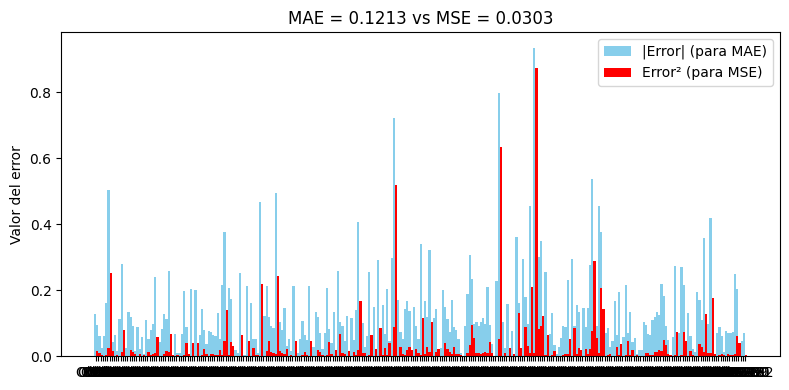

In [8]:

errores=y_test-y_pred_ols
errores_cuadraticos_ols=(errores)**2
errores_absolutos_ols=np.abs(errores)
# Gráfico
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(y_test))

bar_width = 1
ax.bar(x - bar_width/2, errores_absolutos_ols, width=bar_width, label='|Error| (para MAE)', color='skyblue')
ax.bar(x + bar_width/2, errores_cuadraticos_ols, width=bar_width, label='Error² (para MSE)', color='red')

# Títulos y etiquetas
ax.set_xticks(x)
ax.set_xticklabels([f'Obs {i+1}' for i in x])
ax.set_ylabel('Valor del error')
ax.set_title(f'MAE = {mae_ols:.4f} vs MSE = {mse_ols:.4f}')
ax.legend()
plt.tight_layout()
plt.show()

### 4. Regresión con Regularización: Ridge (L2) y Lasso (L1)

<p>Con el objetivo ya transformado, ahora `alpha` tendrá el efecto esperado. Usaremos un valor pequeño para ver el contraste.</p>

In [9]:
# --- Ridge Regression (L2) ---
ridge_model = Ridge(alpha=100.) # Alpha grande
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("--- Evaluación del Modelo Ridge (alpha=100.) ---")
print(f"Error Cuadrático Medio (MSE en escala log): {mse_ridge:.4f}")
print(f"Coeficiente de Determinación (R²): {r2_ridge:.4f}")

# --- Lasso Regression (L1) ---
lasso_model = Lasso(alpha=0.1) # Alpha pequeño
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n--- Evaluación del Modelo Lasso (alpha=0.1) ---")
print(f"Error Cuadrático Medio (MSE en escala log): {mse_lasso:.4f}")
print(f"Coeficiente de Determinación (R²): {r2_lasso:.4f}")

# Comparar coeficientes

coef_df['Coef_Ridge_alpha100'] = ridge_model.coef_
coef_df['Coef_Lasso_alpha0.1'] = lasso_model.coef_
print("\n--- Comparación de Coeficientes ---")
print(coef_df.round(4))

--- Evaluación del Modelo Ridge (alpha=100.) ---
Error Cuadrático Medio (MSE en escala log): 0.0310
Coeficiente de Determinación (R²): 0.8340

--- Evaluación del Modelo Lasso (alpha=0.1) ---
Error Cuadrático Medio (MSE en escala log): 0.0579
Coeficiente de Determinación (R²): 0.6895

--- Comparación de Coeficientes ---
             Coeficiente_OLS  Coef_Ridge_alpha100  Coef_Lasso_alpha0.1
GrLivArea             0.1266               0.1120               0.0567
OverallQual           0.1384               0.1285               0.1479
YearBuilt             0.0744               0.0673               0.0050
TotalBsmtSF           0.0445               0.0499               0.0060
FullBath             -0.0069               0.0080               0.0000
GarageCars            0.0715               0.0723               0.0486


<p>¡Ahora sí! Observa cómo los coeficientes de Ridge son sistemáticamente más pequeños (encogidos) que los de OLS. Y más importante, mira los coeficientes de Lasso: con un `alpha` de solo 0.1, ¡ya ha reducido el coeficiente de `FullBath` casi a cero, demostrando su poder de selección de características!</p>

### 5. Selección de Hiperparámetros con Validación Cruzada

<p>Finalmente, usamos `RidgeCV` y `LassoCV` para encontrar el `alpha` óptimo de manera automática.</p>

In [10]:
# Definir un rango de alphas para probar
alphas = np.logspace(-4, 2, 100)

# --- RidgeCV ---
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_cv.fit(X_train_scaled, y_train)

print("--- Búsqueda del mejor Alpha para Ridge ---")
print(f"Mejor alpha encontrado para Ridge: {ridge_cv.alpha_:.4f}")

# Evaluar el modelo Ridge final con el mejor alpha
y_pred_ridge_cv = ridge_cv.predict(X_test_scaled)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
r2_ridge_cv = r2_score(y_test, y_pred_ridge_cv)
print(f"MSE de Ridge con CV: {mse_ridge_cv:.4f}")
print(f"R² de Ridge con CV: {r2_ridge_cv:.4f}")

# --- LassoCV ---
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
print("\n--- Búsqueda del mejor Alpha para Lasso ---")
print(f"Mejor alpha encontrado para Lasso: {lasso_cv.alpha_:.4f}")

# Evaluar el modelo Lasso final
y_pred_lasso_cv = lasso_cv.predict(X_test_scaled)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
r2_lasso_cv = r2_score(y_test, y_pred_lasso_cv)
print(f"MSE de Lasso con CV: {mse_lasso_cv:.4f}")
print(f"R² de Lasso con CV: {r2_lasso_cv:.4f}")

# Añadir los coeficientes finales al DataFrame
coef_df['Coef_Ridge_CV'] = ridge_cv.coef_
coef_df['Coef_Lasso_CV'] = lasso_cv.coef_
print("\n--- Comparación Final de Coeficientes ---")
print(coef_df.round(4))

--- Búsqueda del mejor Alpha para Ridge ---
Mejor alpha encontrado para Ridge: 86.9749
MSE de Ridge con CV: 0.0309
R² de Ridge con CV: 0.8346

--- Búsqueda del mejor Alpha para Lasso ---
Mejor alpha encontrado para Lasso: 0.0043
MSE de Lasso con CV: 0.0307
R² de Lasso con CV: 0.8357

--- Comparación Final de Coeficientes ---
             Coeficiente_OLS  Coef_Ridge_alpha100  Coef_Lasso_alpha0.1  \
GrLivArea             0.1266               0.1120               0.0567   
OverallQual           0.1384               0.1285               0.1479   
YearBuilt             0.0744               0.0673               0.0050   
TotalBsmtSF           0.0445               0.0499               0.0060   
FullBath             -0.0069               0.0080               0.0000   
GarageCars            0.0715               0.0723               0.0486   

             Coef_Ridge_CV  Coef_Lasso_CV  
GrLivArea           0.1135         0.1199  
OverallQual         0.1297         0.1385  
YearBuilt           0.

### 6. Desafíos para Experimentar

<p>Ahora es tu turno de experimentar. Responde a las siguientes preguntas modificando el código anterior:</p>
<ol>
    <li><strong>Añadir más características:</strong> Elige otras 2 o 3 características numéricas del `df` original, añádelas a la lista `numeric_features` y vuelve a ejecutar todo el notebook. ¿Mejora el R² del modelo final?</li>
    <li><strong>Interpretación de coeficientes:</strong> Observa los coeficientes finales del modelo `LassoCV`. ¿Qué característica parece ser la más importante según este modelo? ¿Cuáles ha descartado (coeficiente cercano a cero)?</li>
    <li><strong>Evaluación en escala original:</strong> Las predicciones (`y_pred_lasso_cv`) están en escala logarítmica. Usa `np.expm1()` para convertirlas de nuevo a dólares. Luego, calcula el Error Absoluto Medio (MAE) entre las predicciones revertidas y el `y_test` original (que deberías haber guardado como `y_raw`). ¿Cuál es el error promedio en dólares de tu mejor modelo?</li>
</ol>

In [11]:
# MSE de Lasso con CV: 0.0307
# R² de Lasso con CV: 0.8357

# Para el OLS simple el R^2 da 0.8604
# R² de Ridge con CV: 0.8555
# R² de Lasso con CV: 0.8574

# La caracteristica mas importante parece ser OverallQual
# Descarto LotFrontage (la que agregue) y FullBath

y_pred_lasso_cv_original=np.expm1(y_pred_lasso_cv)
#mean_absolute_error

### 7. Ejercicios Propuestos

<div class="alert alert-block alert-warning">
<h4>Ejercicios para Solidificar Conceptos</h4>
<ol>
    <li><strong>Evaluación de Residuos:</strong> Para el mejor modelo que encontraste (probablemente RidgeCV o LassoCV), calcula los residuos ($y_{test} - \hat{y}$) y crea un gráfico de dispersión de los valores predichos vs. los residuos. ¿Observas algún patrón? Un patrón podría indicar que la relación no es puramente lineal.</li>
    <li><strong>Cambiar la Métrica de CV:</strong> En `LassoCV` y `RidgeCV`, el scoring por defecto es el error cuadrático negativo. Investiga cómo podrías usar el "mean_absolute_error" en su lugar. ¿Cambia el `alpha` seleccionado?</li>
    <li><strong>Implementar K-Fold a Mano:</strong> En lugar de usar `RidgeCV`, instancia un `KFold(n_splits=5)`, itera sobre los pliegues, entrena un modelo `Ridge` para un alpha fijo en cada pliegue y calcula el error promedio. Compara tu resultado con el de la clase `RidgeCV`.</li>
    <li><strong>Características Polinómicas:</strong> Sospechamos que la relación entre `GrLivArea` y `SalePrice` no es perfectamente lineal. Usa `sklearn.preprocessing.PolynomialFeatures` para crear una característica `GrLivArea` al cuadrado y añádela al modelo. ¿Mejora el R²?</li>
    <li><strong>Impacto de Outliers:</strong> Encuentra la casa más cara en el `df_subset`. Elimínala y vuelve a entrenar el modelo OLS (con el target logarítmico). ¿Cómo cambian los coeficientes y el R²?</li>
    <li><strong>Comparar MAE vs MSE:</strong> Calcula el `mean_absolute_error` (MAE) para todos los modelos finales (OLS, RidgeCV, LassoCV) en la escala logarítmica. ¿Por qué el MAE es menor que el MSE?</li>
    <li><strong>Importancia de Características:</strong> Ordena los coeficientes del modelo `RidgeCV` final de mayor a menor en valor absoluto. ¿Cuáles son las 3 características más influyentes según este modelo?</li>
    <li><strong>Efecto del Alpha en Lasso:</strong> Crea un gráfico que muestre cómo cambian los coeficientes de Lasso a medida que `alpha` aumenta. Puedes usar la información almacenada en `lasso_cv.path_`.</li>
    <li><strong>Regresión Lineal Simple vs. Múltiple:</strong> Entrena un modelo de regresión lineal simple para cada una de las características en `numeric_features` por separado. Compara el coeficiente de cada característica en su modelo simple con su coeficiente en el modelo múltiple (OLS). ¿Por qué son diferentes?</li>
    <li><strong>Modelo para Producción:</strong> Si tuvieras que elegir uno de los modelos entrenados para ponerlo en producción y predecir precios de casas para un cliente, ¿cuál elegirías y por qué? Justifica tu respuesta basándote en el rendimiento (R², MSE), la interpretabilidad (coeficientes) y la simplicidad del modelo.</li>
</ol>
</div>

# PREGUNTAS

1. En la celda 10 dibuja el log1() que diferencia hay entre hacer eso y el log a fines estadísticos? Graficamente me da lo mismo
2. Cuando calculamos los predictores en la forma que lo hicimos no estamos teniendo en cuenta los p-values de cada uno. Es que no importan?

# Evaluación de residuos
- Para el mejor modelo calcular los residuos $y_{test}-\hat{y}$. 
- Crear un gráfico de dispersión de los valores predichos vs los residuos. 


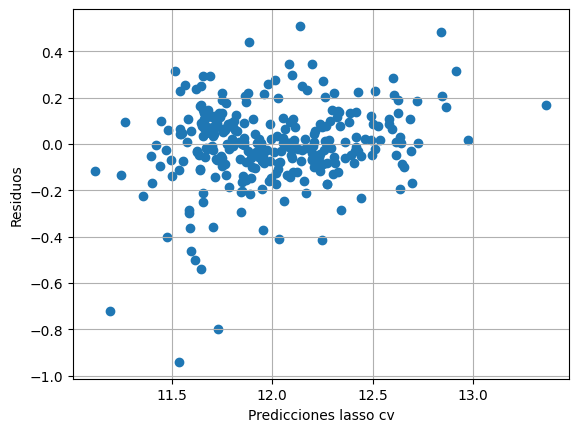

In [12]:
import matplotlib.pyplot as plt
#El mejor modelo es el de lasso
residuos=y_test-y_pred_lasso_cv

plt.scatter(x=y_pred_lasso_cv,y=residuos)
plt.xlabel("Predicciones lasso cv")
plt.ylabel("Residuos")
plt.grid()
plt.show()

### Se observa que para las predicciones estan entre 11.5 y 12.5 alrededor del 0, pero existen algunas desviaciones hacia |0.2| es posible que no sea puramente lineal

# 2. Cambiar la métrica de CV en LassoCV y RidgeCV. El scoring por defecto es el error cuadratico negativo. Investigar como se podría usar el "mean_absolute_error" en su lugar. Cambia el alpha seleccionado?


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer

# Definir un rango de alphas para probar
alphas = np.logspace(-4, 2, 100)

# --- RidgeCV ---
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True,scoring='neg_mean_absolute_error')
ridge_cv.fit(X_train_scaled, y_train)

print("--- Búsqueda del mejor Alpha para Ridge ---")
print(f"Mejor alpha encontrado para Ridge: {ridge_cv.alpha_:.4f}")

# Evaluar el modelo Ridge final con el mejor alpha
y_pred_ridge_cv = ridge_cv.predict(X_test_scaled)
mae_ridge_cv = mean_absolute_error(y_test, y_pred_ridge_cv)
r2_ridge_cv = r2_score(y_test, y_pred_ridge_cv)
print(f"MAE de Ridge con CV: {mae_ridge_cv:.4f}")
print(f"R² de Ridge con CV: {r2_ridge_cv:.4f}")

# --- LassoCV ---
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

lasso_cv_for_grid = Lasso(max_iter=1000)

lasso_cv_grid = GridSearchCV(estimator=lasso_cv_for_grid,
                    param_grid={'alpha': alphas},
                    scoring=mae_scorer,
                    cv=5)

lasso_cv_grid.fit(X_train_scaled, y_train)

print("\n--- Búsqueda del mejor Alpha para Lasso ---")
print(f"Mejor alpha encontrado para Lasso: {lasso_cv_grid.best_params_['alpha']:.4f}")

# Evaluar el modelo Lasso final
y_pred_lasso_cv = lasso_cv_grid.predict(X_test_scaled)
mae_lasso_cv = mean_absolute_error(y_test, y_pred_lasso_cv)
r2_lasso_cv = r2_score(y_test, y_pred_lasso_cv)
print(f"MAE de Lasso con CV: {mae_lasso_cv:.4f}")
print(f"R² de Lasso con CV: {r2_lasso_cv:.4f}")

lasso_best = lasso_cv_grid.best_estimator_


# Añadir los coeficientes finales al DataFrame
coef_df['Coef_Ridge_CV MAE'] = ridge_cv.coef_
coef_df['Coef_Lasso_CV MAE '] = lasso_best.coef_
print("\n--- Comparación Final de Coeficientes ---")
print(coef_df.round(4))


mse_mae_lasso=[mse_lasso_cv,mae_lasso_cv]
mse_mae_ridge=[mse_ridge_cv,mae_ridge_cv]
mse_vs_mae['lasso_cv']=mse_mae_lasso
mse_vs_mae['ridge_cv']=mse_mae_ridge

--- Búsqueda del mejor Alpha para Ridge ---
Mejor alpha encontrado para Ridge: 21.5443
MAE de Ridge con CV: 0.1213
R² de Ridge con CV: 0.8370

--- Búsqueda del mejor Alpha para Lasso ---
Mejor alpha encontrado para Lasso: 0.0001
MAE de Lasso con CV: 0.1213
R² de Lasso con CV: 0.8375

--- Comparación Final de Coeficientes ---
             Coeficiente_OLS  Coef_Ridge_alpha100  Coef_Lasso_alpha0.1  \
GrLivArea             0.1266               0.1120               0.0567   
OverallQual           0.1384               0.1285               0.1479   
YearBuilt             0.0744               0.0673               0.0050   
TotalBsmtSF           0.0445               0.0499               0.0060   
FullBath             -0.0069               0.0080               0.0000   
GarageCars            0.0715               0.0723               0.0486   

             Coef_Ridge_CV  Coef_Lasso_CV  Coef_Ridge_CV MAE  \
GrLivArea           0.1135         0.1199             0.1227   
OverallQual         0.1297

### Como se puede ver si ha cambiado el alpha tanto para Ridge como para Lasso

# 3. Implementación de K-Fold a Mano: En lugar de usar RidgeCv instancia KFlold(n_splits=5) iterar sobre los pliegue, entrenar un modelo Ridge para un alpha fijo en cada pliegue y calcula el error promedio. 

In [14]:
from sklearn.model_selection import KFold

kf=KFold(n_splits=5,shuffle=True,random_state=42)

ridge_fold=Ridge(alpha=86.9749)

mse_scores=[]

for fold,(train_index,test_index) in enumerate(kf.split(X_train_scaled)):
   X_train_fold,X_test_fold=X_train_scaled.iloc[train_index],X_train_scaled.iloc[test_index]
   y_train_fold,y_test_fold=y_train.iloc[train_index],y_train.iloc[test_index]

   ridge_fold.fit(X_train_fold,y_train_fold)
   predictions_fold=ridge_fold.predict(X_test_fold)
   mse_fold=mean_squared_error(y_test_fold,predictions_fold)
   mse_scores.append(mse_fold)

print(f"MSE promedio usando k-fold con Ridge: {np.mean(mse_scores):.4f}")
print(f"MSE usando RidgeCV: 0.0309")



MSE promedio usando k-fold con Ridge: 0.0324
MSE usando RidgeCV: 0.0309


# 4. Características polinómicas usar PolynomialFeatures para crear una ${GrLivArea^2}$

In [15]:
coef_df.loc['GrLivArea^2']=[None]*len(coef_df.columns)

/var/folders/jr/t_k402pj3bg57t7p56rgmknr0000gn/T/ipykernel_89023/4164825938.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [16]:
from sklearn.preprocessing import PolynomialFeatures

X_train_scaled.head()
# En este caso creo que es mas facil agregar la columan elevada al cuadrado y listo

poly=PolynomialFeatures(degree=2)
X_poly_train=poly.fit_transform(X_train_scaled[['GrLivArea']])

X_poly_test=poly.fit_transform(X_test_scaled[['GrLivArea']])

column_names=poly.get_feature_names_out(['GrLivArea'])
df_poly_train=pd.DataFrame(X_poly_train,columns=column_names)
df_poly_test=pd.DataFrame(X_poly_test,columns=column_names)
X_train_scaled_augmented=pd.concat([X_train_scaled,df_poly_train[['GrLivArea^2']]],axis=1)
X_test_scaled_augmented=pd.concat([X_test_scaled,df_poly_test[['GrLivArea^2']]],axis=1)





# Definir un rango de alphas para probar
alphas = np.logspace(-4, 2, 100)

# --- RidgeCV ---
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_cv.fit(X_train_scaled_augmented, y_train)

print("--- Búsqueda del mejor Alpha para Ridge ---")
print(f"Mejor alpha encontrado para Ridge: {ridge_cv.alpha_:.4f}")

# Evaluar el modelo Ridge final con el mejor alpha
y_pred_ridge_cv = ridge_cv.predict(X_test_scaled_augmented)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
r2_ridge_cv = r2_score(y_test, y_pred_ridge_cv)
print(f"MSE de Ridge con CV: {mse_ridge_cv:.6f}")
print(f"R² de Ridge con CV: {r2_ridge_cv:.6f}")

# --- LassoCV ---
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train_scaled_augmented, y_train)

print("\n--- Búsqueda del mejor Alpha para Lasso ---")
print(f"Mejor alpha encontrado para Lasso: {lasso_cv.alpha_:.4f}")

# Evaluar el modelo Lasso final
y_pred_lasso_cv = lasso_cv.predict(X_test_scaled_augmented)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
r2_lasso_cv = r2_score(y_test, y_pred_lasso_cv)
print(f"MSE de Lasso con CV: {mse_lasso_cv:.6f}")
print(f"R² de Lasso con CV: {r2_lasso_cv:.6f}")

# Añadir los coeficientes finales al DataFrame
coef_df['Coef_Ridge_CV ^2'] = ridge_cv.coef_
coef_df['Coef_Lasso_CV ^2'] = lasso_cv.coef_
print("\n--- Comparación Final de Coeficientes ---")
print(coef_df.round(4))




--- Búsqueda del mejor Alpha para Ridge ---
Mejor alpha encontrado para Ridge: 0.0001
MSE de Ridge con CV: 0.030816
R² de Ridge con CV: 0.834865

--- Búsqueda del mejor Alpha para Lasso ---
Mejor alpha encontrado para Lasso: 0.0001
MSE de Lasso con CV: 0.030806
R² de Lasso con CV: 0.834916

--- Comparación Final de Coeficientes ---
             Coeficiente_OLS  Coef_Ridge_alpha100  Coef_Lasso_alpha0.1  \
GrLivArea             0.1266               0.1120               0.0567   
OverallQual           0.1384               0.1285               0.1479   
YearBuilt             0.0744               0.0673               0.0050   
TotalBsmtSF           0.0445               0.0499               0.0060   
FullBath             -0.0069               0.0080               0.0000   
GarageCars            0.0715               0.0723               0.0486   
GrLivArea^2              NaN                  NaN                  NaN   

             Coef_Ridge_CV  Coef_Lasso_CV  Coef_Ridge_CV MAE  \
GrLivArea

### El R^2 pasa de 0.8370 a 0.8349, no mejora, empeora

# 5. Impacto de los outliers. Encuentra la casa mas cara en el df_subset. Elminala y vuelve a entrenar el modelo OLS con el target logarítmico. Como cambian los coeficientes y el R^2?

In [17]:
fila_precio_maximo=df_subset['SalePrice'].idxmax()
print(fila_precio_maximo)
df[fila_precio_maximo:fila_precio_maximo+1]

df_subset=df_subset.drop(index=fila_precio_maximo)

fila_precio_maximo=df_subset['SalePrice'].idxmax()
print(fila_precio_maximo)



691
1182


In [18]:

# 1. Definir características (X) y objetivo (y)

X = df_subset[numeric_features]
y_raw = df_subset[target_variable] # Guardamos el 'y' original para evaluación final

# !! CAMBIO CLAVE !!
# Aplicamos la transformación logarítmica a la variable objetivo 'y'
# Esto estabiliza la varianza y normaliza la escala del problema.
y = np.log1p(y_raw)

# 2. Dividir en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")

# 3. Escalar las características numéricas. (Normalizamos lo datos para que esten en el mismo rango)
scaler = StandardScaler()

# Ajustamos el escalador SOLO con los datos de entrenamiento para evitar fuga de datos (data leakage)
X_train_scaled = scaler.fit_transform(X_train)  # el fit hace el aprendizaje
# Aplicamos la misma transformación a los datos de prueba
X_test_scaled = scaler.transform(X_test)  # usa el mismo aprendizaje que antes. 

# Convertimos los arrays de numpy de vuelta a DataFrames de pandas para mejor legibilidad
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features)


# Crear y entrenar el modelo de Regresión Lineal
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba (las predicciones estarán en escala logarítmica)
y_pred_ols = ols_model.predict(X_test_scaled)

# Evaluar el modelo
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)

print("--- Evaluación del Modelo de Regresión Lineal (OLS) ---")
print(f"Error Cuadrático Medio (MSE en escala log): {mse_ols:.4f}")
print(f"Coeficiente de Determinación (R²): {r2_ols:.4f}")

# Ver los coeficientes del modelo
row=ols_model.coef_
row=np.append(row,None)

coef_df['Coeficiente_OLS sin outlier']=row
print("\nCoeficientes del modelo OLS:")
print(coef_df)


Tamaño del set de entrenamiento: (1167, 6)
Tamaño del set de prueba: (292, 6)
--- Evaluación del Modelo de Regresión Lineal (OLS) ---
Error Cuadrático Medio (MSE en escala log): 0.0272
Coeficiente de Determinación (R²): 0.8427

Coeficientes del modelo OLS:
             Coeficiente_OLS  Coef_Ridge_alpha100  Coef_Lasso_alpha0.1  \
GrLivArea           0.126585             0.111973             0.056712   
OverallQual         0.138404             0.128540             0.147911   
YearBuilt           0.074407             0.067285             0.004993   
TotalBsmtSF         0.044540             0.049878             0.006045   
FullBath           -0.006889             0.008021             0.000000   
GarageCars          0.071504             0.072289             0.048613   
GrLivArea^2              NaN                  NaN                  NaN   

             Coef_Ridge_CV  Coef_Lasso_CV  Coef_Ridge_CV MAE  \
GrLivArea         0.113471       0.119855           0.122695   
OverallQual       0.12

### Rta: El coeficiente ${R^2}$ quitando el outlayer es de 0.8427 contra un 0.8375 con el outlier

# 6. Compara MAE vs MSE para los modelos OLS, RidgeCV y LasoCV


In [19]:
print(mse_vs_mae)

          OLS  lasso_cv  ridge_cv
MSE  0.030318  0.030657  0.030869
MAE  0.121281  0.121288  0.121340


### MAE no es menor a MSE, MSE es menor a MAE y es porque los errores estan muy cerca del cero 

## 7. Importancia de las caracteristicas: Ordenar los coeficientes del modelo RidgeCV  de mayor a menor en valor absoluto, Cuales son las 3 caracteristicas mas influyentes?

In [20]:
coef_ridge_cv=coef_df['Coef_Ridge_CV']

print(coef_ridge_cv.abs().sort_values())


FullBath       0.006507
TotalBsmtSF    0.049380
YearBuilt      0.067968
GarageCars     0.072278
GrLivArea      0.113471
OverallQual    0.129720
GrLivArea^2         NaN
Name: Coef_Ridge_CV, dtype: float64


### Características mas influyentes
- GarageCars     0.072278
- GrLivArea      0.113471
- OverallQual    0.129720


## Efecto Alpha en Lasso: Crear un gráfico que muestre cómo cambian los coeficientes de Lasso a medida que alpha aumenta. Usar la información guardada en  'lasso_cv.path_'

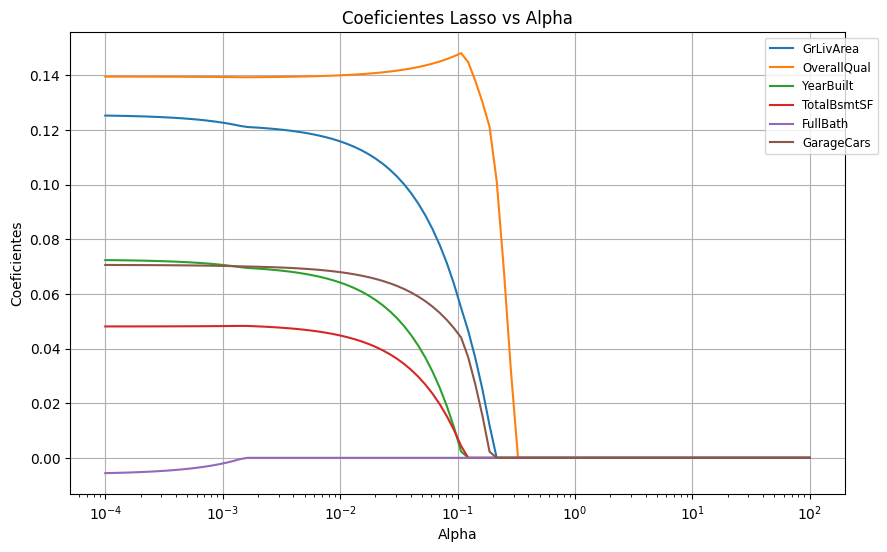

In [21]:
#Aca tengo que hacer un Lasso e ir aumentando el alpha porque no hay una variable path_ en la clase Lasso
coefs=[]
feature_names=X_train_scaled.columns
# Ajustamos Lasso para cada alpha
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)
coefs=np.array(coefs)
# Graficamos
plt.figure(figsize=(10, 6))
for i, name in enumerate(feature_names):
    plt.plot(alphas, coefs[:, i], label=name)

plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Coeficientes")
plt.title("Coeficientes Lasso vs Alpha")
plt.legend(loc='best', fontsize='small', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

## 9. Regression lineal vs regesion multiple: Entrenar un modelo de regresión lineal simple para cada una de las características en numeric features. Comparar el coefciente con el de la regresíon múltiple. Determinar porque son diferentes.


In [22]:
# Crear y entrenar el modelo de Regresión Lineal
coef_per_feature=[]
for i,feature in enumerate(numeric_features):
    X_train_feature=X_train_scaled[[feature]]
    regression_model=LinearRegression()
    regression_model.fit(X_train_feature,y_train)
    coef_per_feature.append(regression_model.coef_)

coef_reg_per_feature = pd.DataFrame(coef_per_feature, index=numeric_features, columns=['coeficientes_ols_per_feature'])
coef_reg_per_feature['OLS multiple']=ols_model.coef_
print(coef_reg_per_feature)


             coeficientes_ols_per_feature  OLS multiple
GrLivArea                        0.271114      0.125544
OverallQual                      0.316801      0.139523
YearBuilt                        0.228113      0.072556
TotalBsmtSF                      0.233728      0.048065
FullBath                         0.226524     -0.005993
GarageCars                       0.265968      0.070626


La diferencia radica en las dimensiones, con un feature es una recta, con dos un plano y asi sucesivamente, a medida que se agregan features el modelo toma mas dimensiones y ajusta por una figura geometrica diferente

### 10. Modelo para producción. 
En función del MSE el R^2 me quedo con el LassoCV porque si bien otros modelos tienen un un mayor R^2 la simplejza del modelo amerita elegirlo por sobre el que tiene variables al cuadrado.

# Probamos con una regresion OLS pero observando los p-values

In [32]:
import statsmodels.api as sm

print(type(X_train_scaled))
print(type(y_train))
print(len(y_train))
print(len(X_train_scaled))
X_new=sm.add_constant(X_train_scaled)
ols_model_simple = sm.OLS(y_train, X_new).fit()
#results = ols_model_simple.fit()

#sm.OLS

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
1167
1167


ValueError: The indices for endog and exog are not aligned